In [1]:
%matplotlib inline
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import cv2
import re
import util
from model import AffineNet
from model import NetMain
import train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
path = "DATA2/Results/AffineNetwork/"

#### load the training set ####
imgs_rgb_train, imgs_ir_train = util.loadDataset(path, "train/rgb", "train/ir")

imgs_mask_rgb_train, imgs_mask_ir_train = util.loadDataset(path, "train/mask_rgb", "train/mask_ir", color=False)

In [3]:
#### load the test set ####
imgs_rgb_test, imgs_ir_test = util.loadDataset(path, "test/rgb", "test/ir")

imgs_mask_rgb_test, imgs_mask_ir_test = util.loadDataset(path, "test/mask_rgb", "test/mask_ir", color=False)

In [4]:
#### load the validation set ####
imgs_rgb_val, imgs_ir_val = util.loadDataset(path, "validation/rgb", "validation/ir")

imgs_mask_rgb_val, imgs_mask_ir_val = util.loadDataset(path, "validation/mask_rgb", "validation/mask_ir", color=False)

In [5]:
imgs_rgb_train.shape, imgs_mask_rgb_train.shape, imgs_rgb_test.shape, imgs_rgb_val.shape

((8000, 240, 320, 3),
 (8000, 240, 320),
 (1400, 240, 320, 3),
 (1000, 240, 320, 3))

In [6]:
beg = 0
end = 8000

# prepare the training frames to be used in the network 
imRGB = util.parseImages(imgs_mask_rgb_train, end)
imRGB = imRGB[beg:end, ...]

imIR = util.parseImages(imgs_mask_ir_train, end)
imIR = imIR[beg:end, ...]

imIR.shape

torch.Size([8000, 1, 240, 320])

In [7]:
beg = 0
end = 1000

# prepare the test frames to be used in the network
imRGB_test = util.parseImages(imgs_mask_rgb_val, end)
imRGB_test = imRGB_test[beg:end, ...]

imIR_test = util.parseImages(imgs_mask_ir_val, end)
imIR_test = imIR_test[beg:end, ...]

imIR_test.shape

torch.Size([1000, 1, 240, 320])

In [9]:
# load the model with a pretrain model with 100 epochs
model = AffineNet().to(device)
model.load_state_dict(torch.load("Model/model_affine_segmentation_e100.pt"))
model.eval()

AffineNet(
  (localization): Sequential(
    (0): Conv2d(2, 32, kernel_size=(7, 7), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 48, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU(inplace=True)
    (6): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 80, kernel_size=(5, 5), stride=(1, 1))
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU(inplace=True)
    (12): Conv2d(80, 100, kernel_size=(3, 3), stride=(1, 1))
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): ReLU(inplace=True)
    (15): Conv2d(100, 120, kernel_size=(3, 3), stride=(1, 1))
    (16): MaxPool2d(kernel_size=2, st

C:\Users\lucaw\Anaconda3\lib\site-packages\torch\nn\functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\lucaw\Anaconda3\lib\site-packages\torch\nn\functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
C:\Users\lucaw\Documents\EPFL\BachelorProjectFinal\util.py:156: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memor

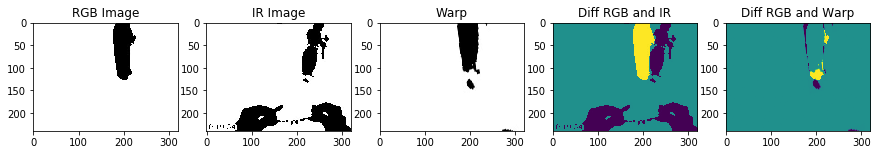

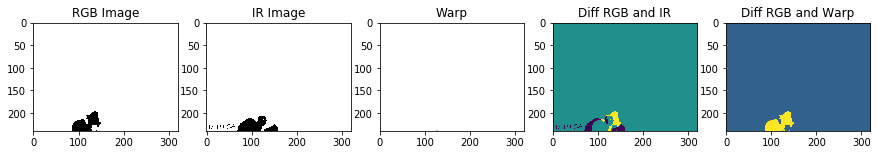

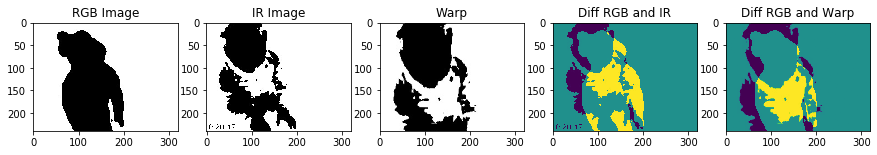

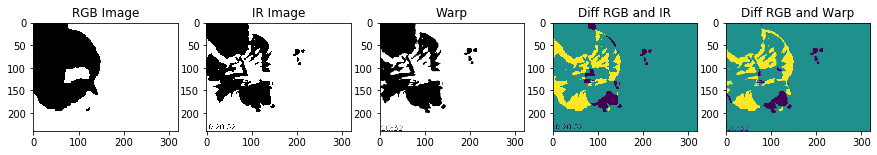

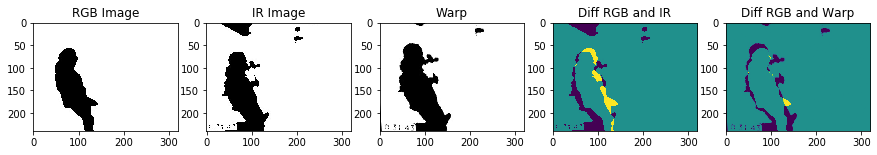

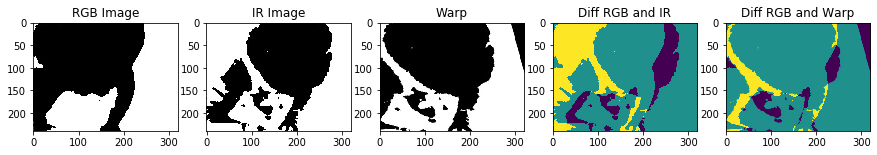

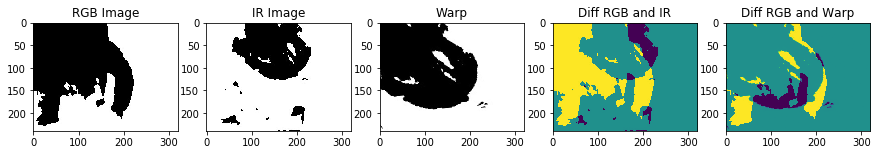

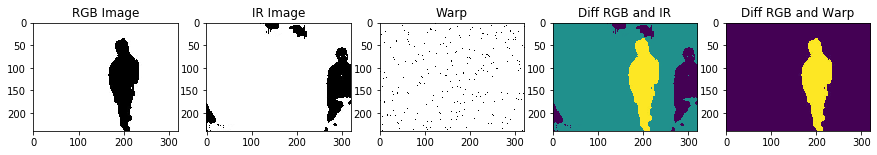

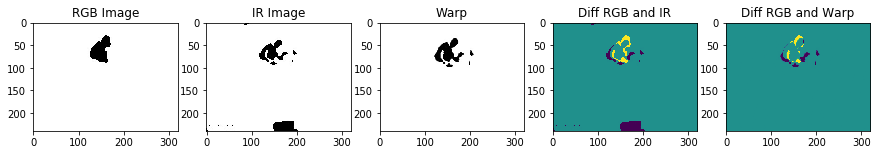

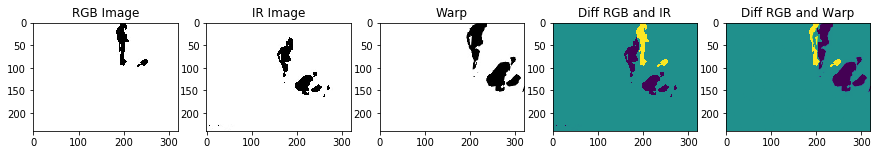

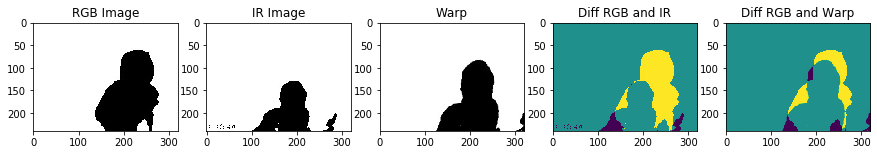

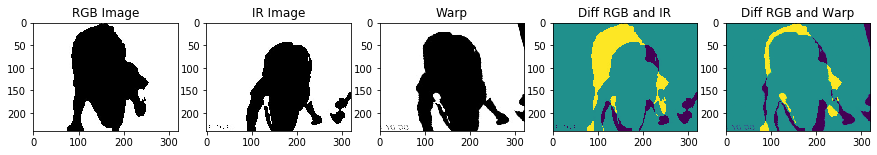

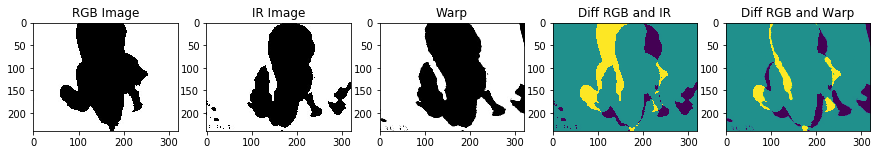

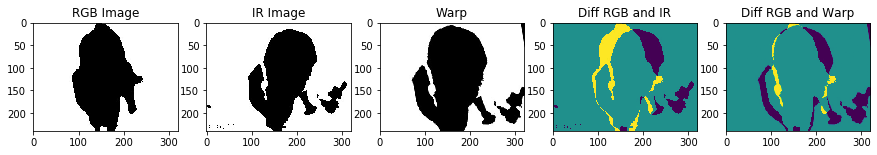

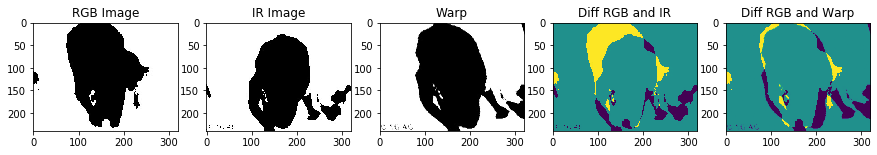

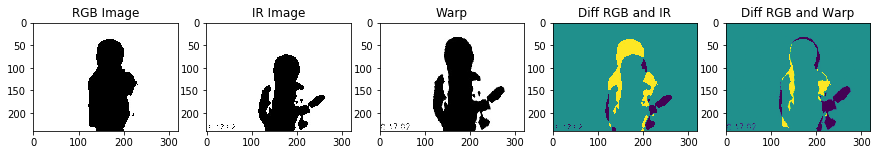

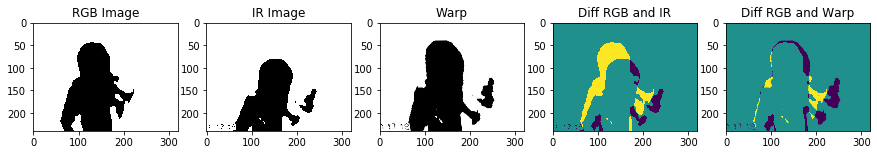

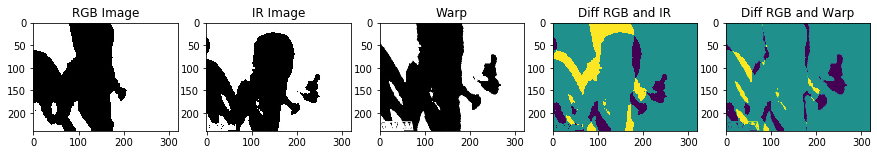

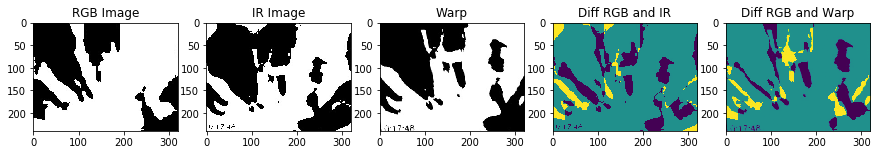

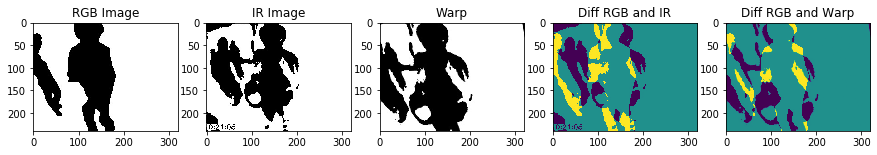

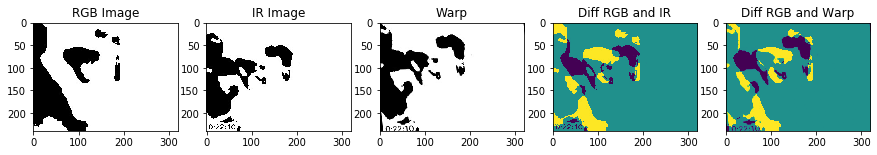

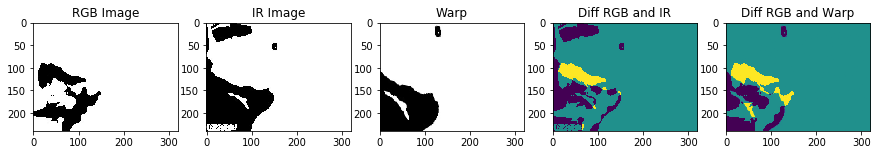

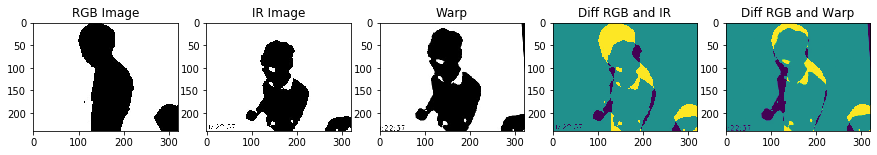

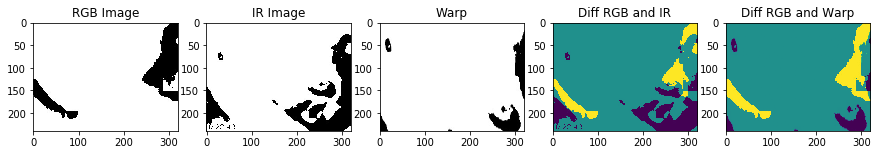

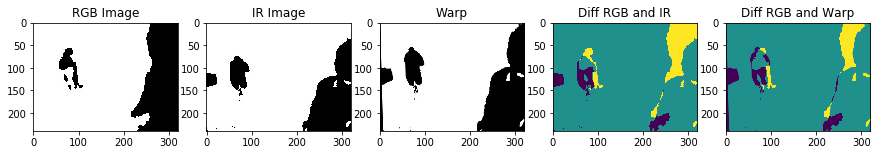

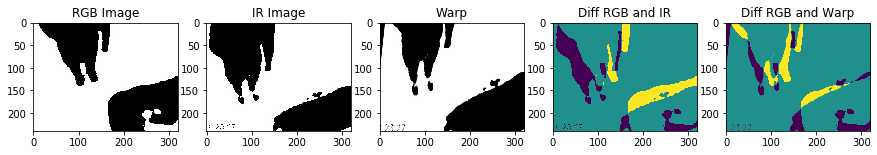

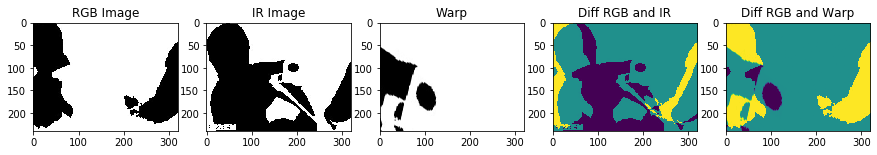

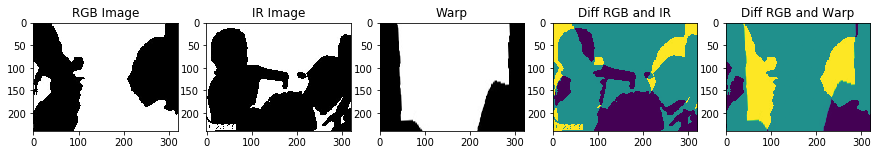

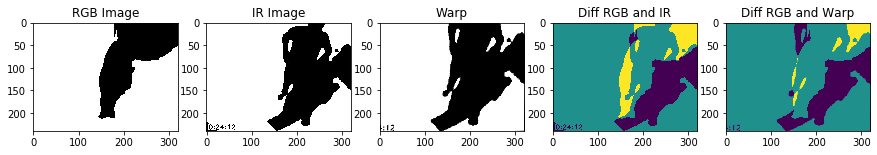

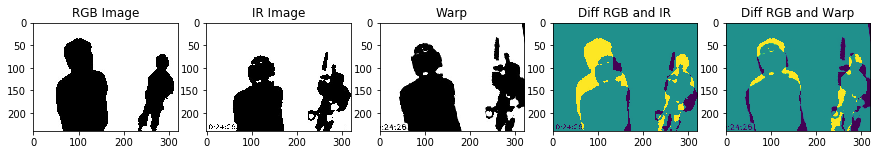

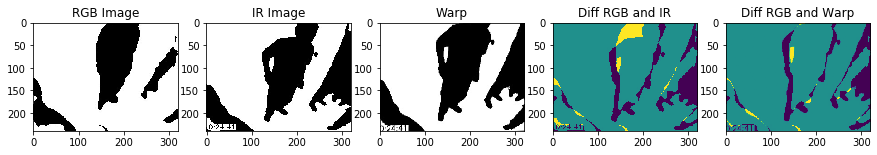

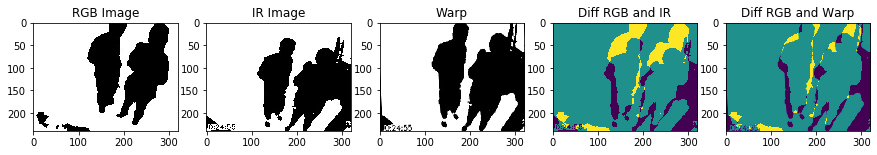

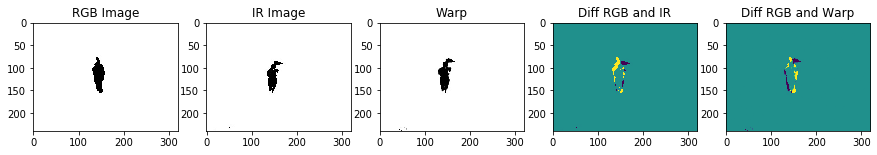

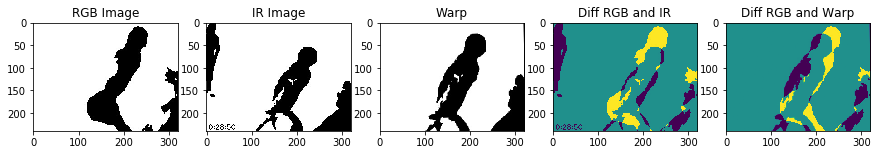

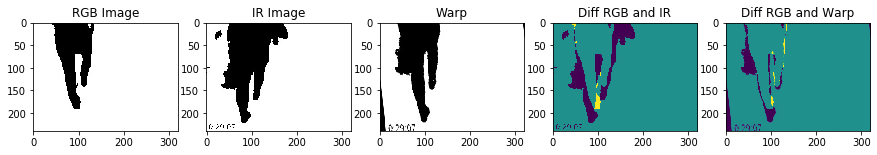

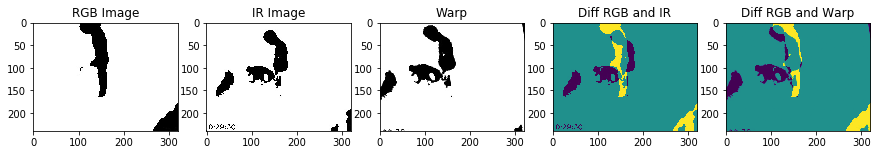

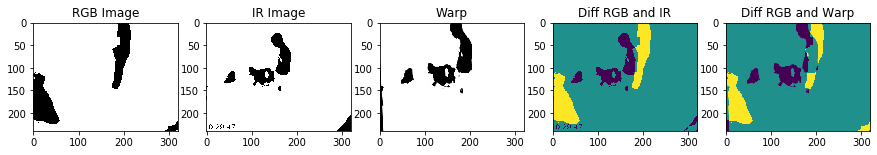

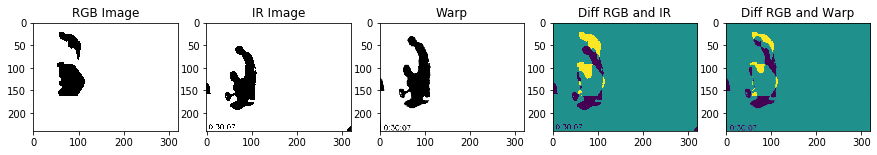

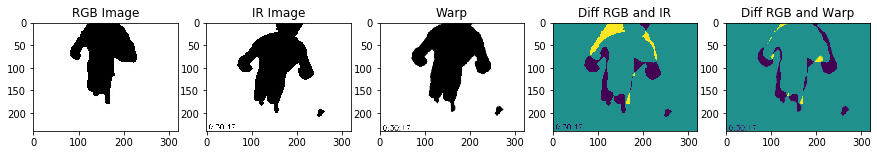

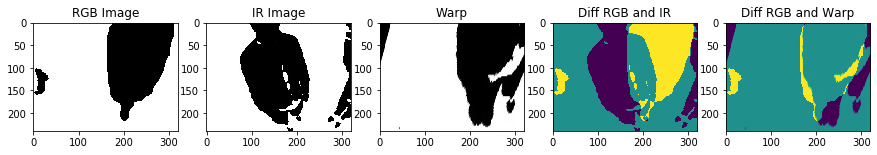

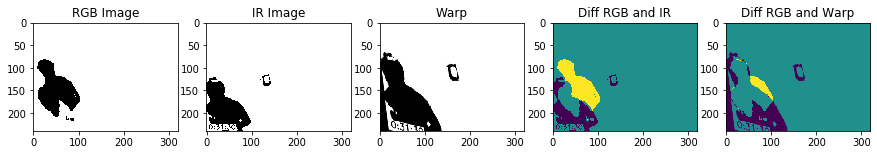

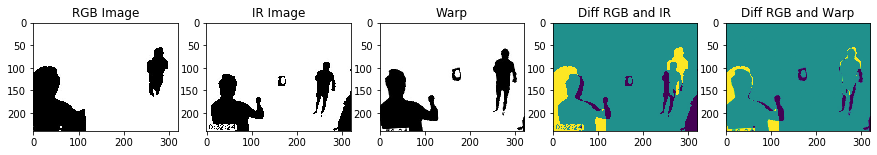

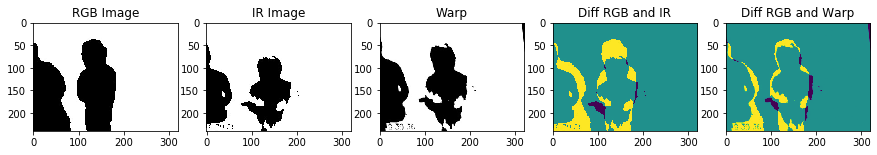

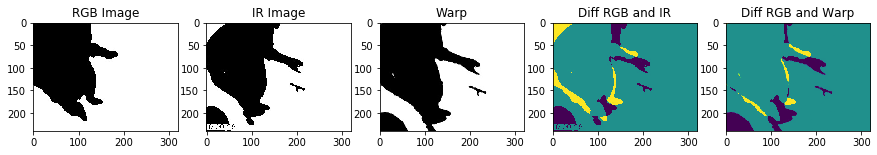

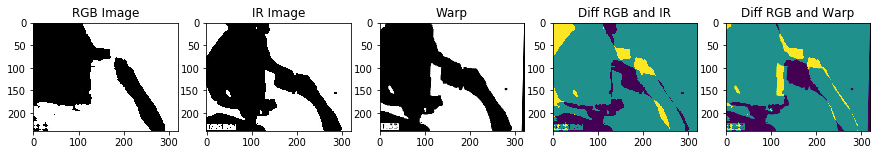

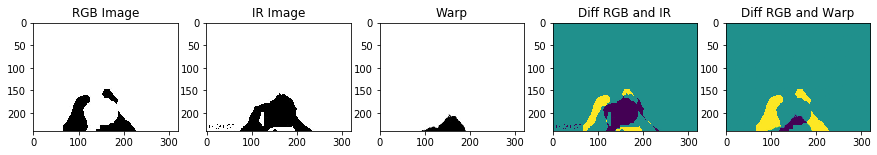

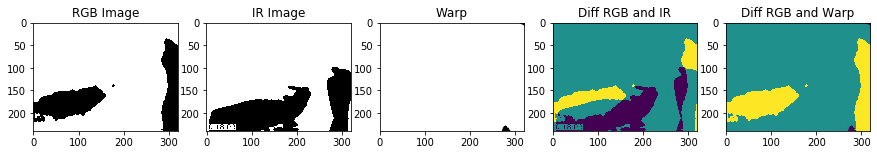

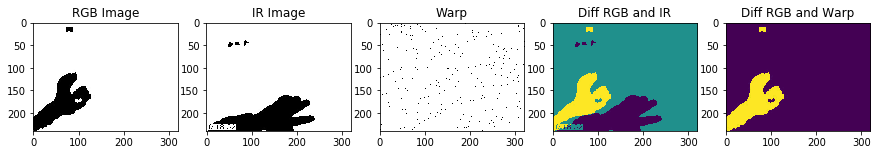

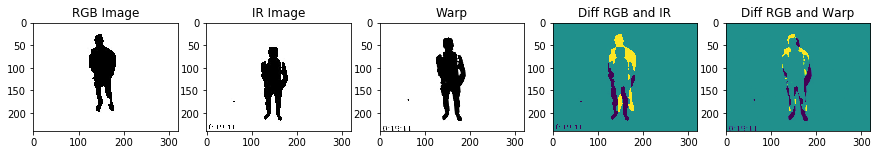

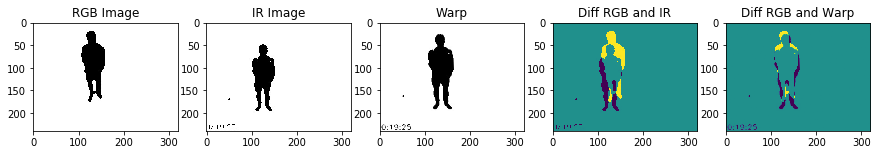

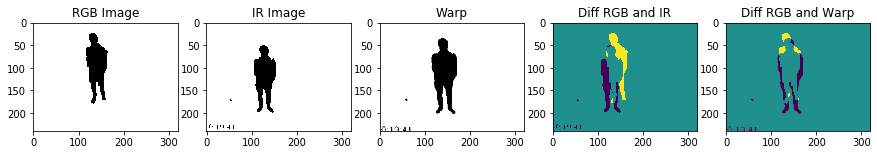

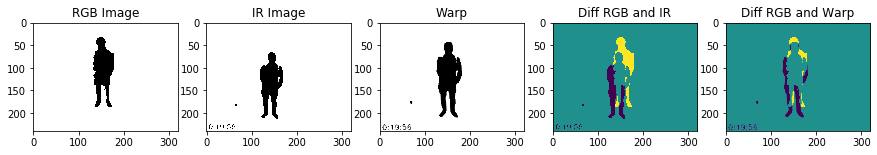

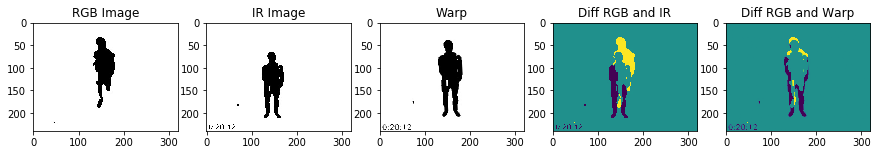

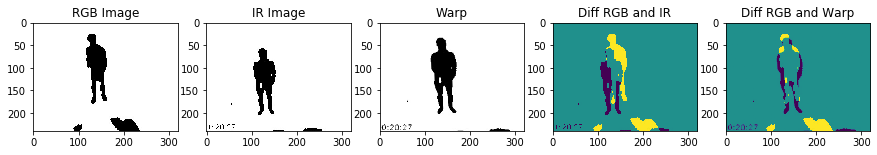

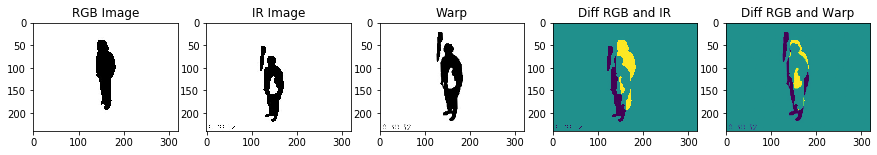

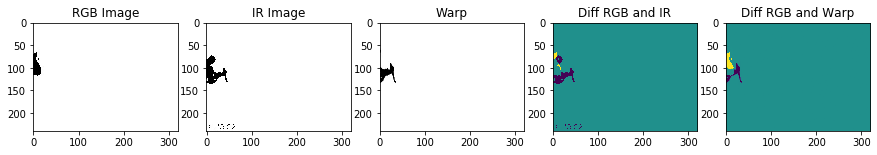

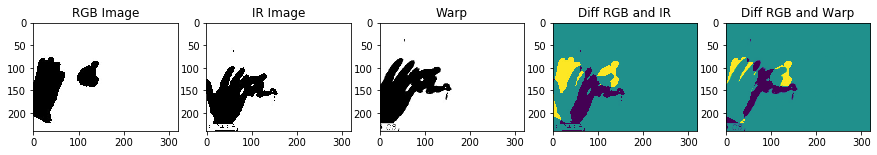

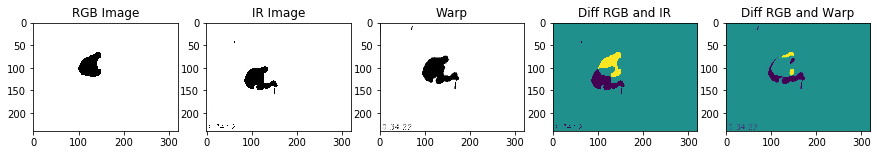

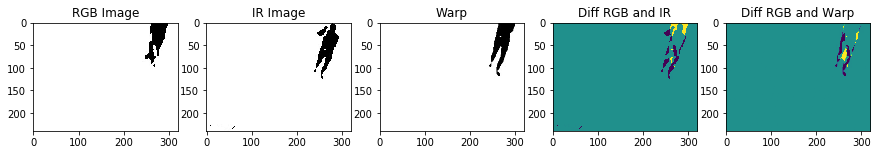

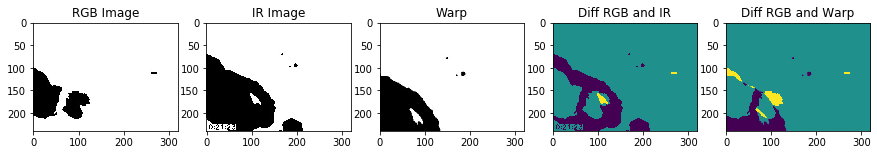

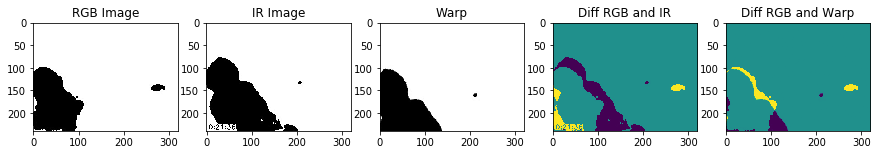

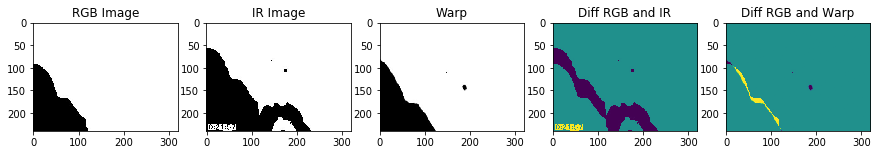

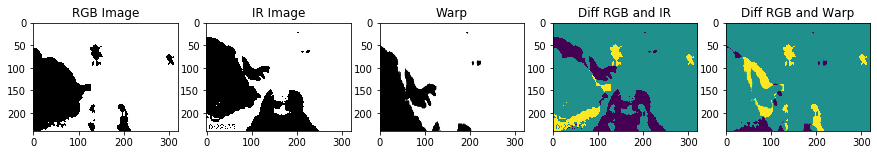

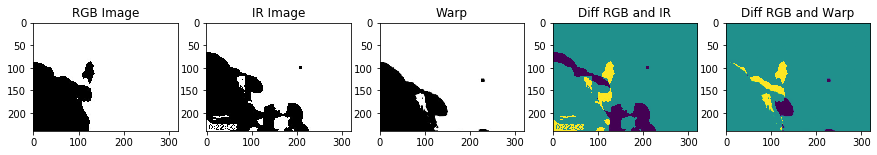

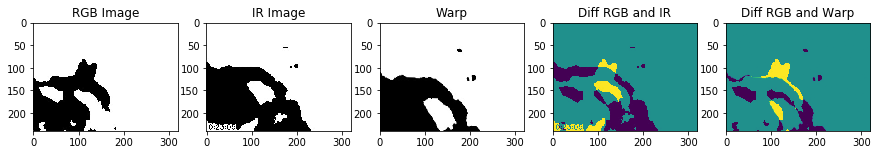

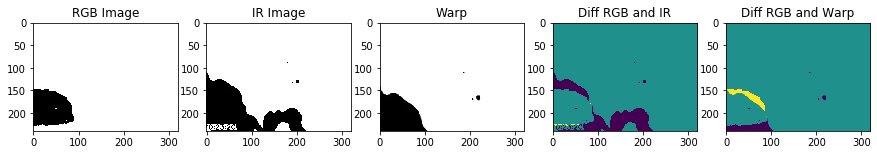

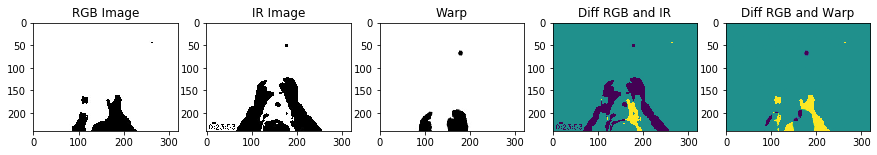

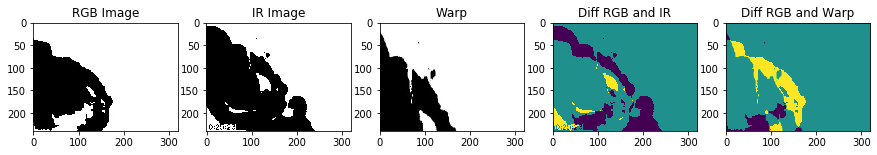

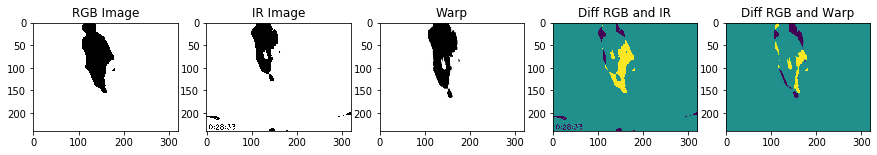

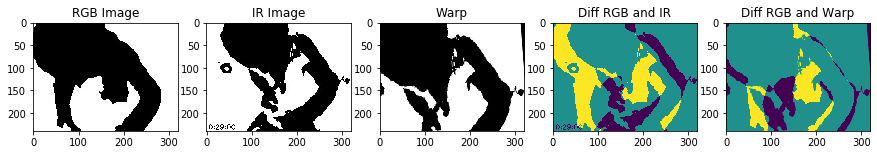

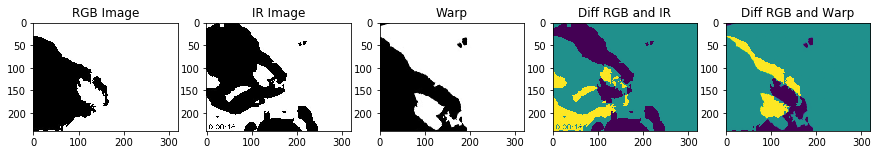

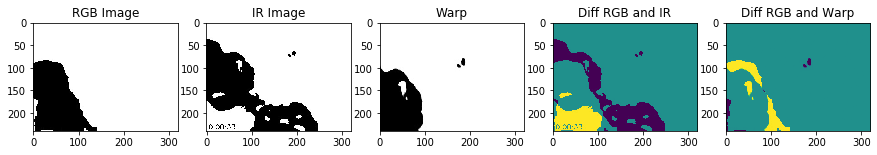

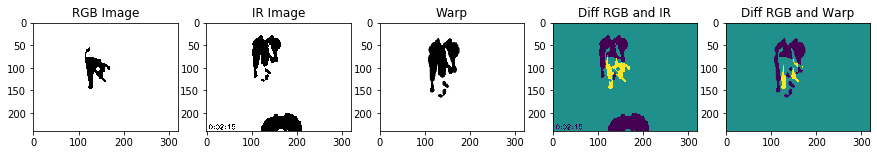

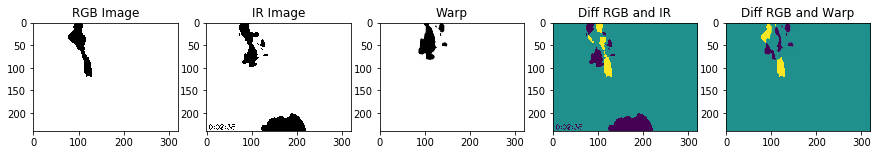

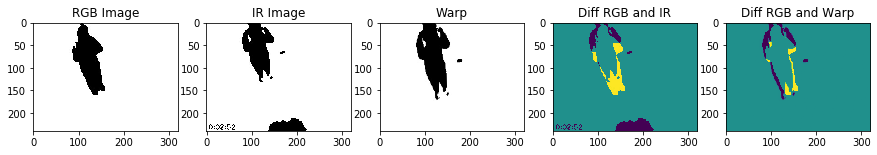

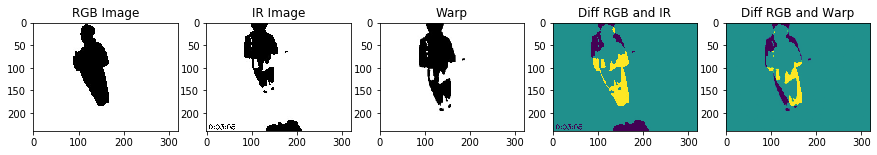

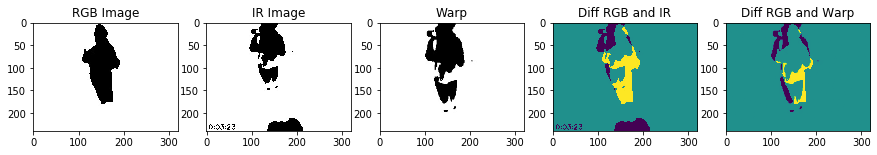

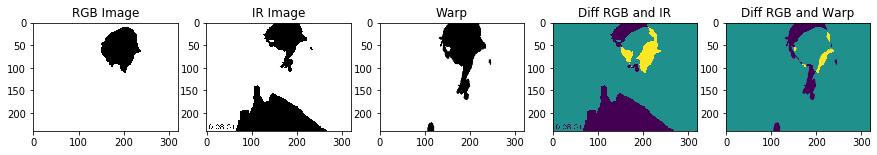

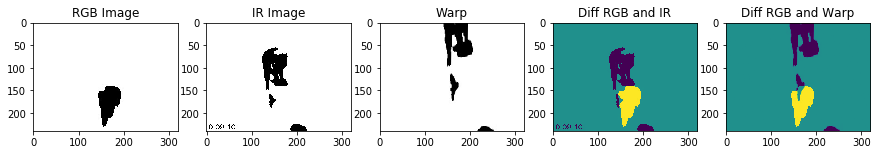

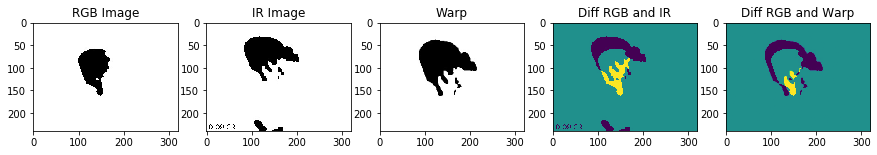

In [10]:
# show the results on the masks
for i in range(0, 8000, 100):
    util.printResult(*util.getImagesById(imRGB.cpu(), imIR.cpu(), i, model.cpu()), cmap='viridis')

In [11]:
# load all the flows (to apply to the original frames)
flows = util.getAllFlows(imIR, imRGB, model)

flows.shape

torch.Size([8000, 240, 320, 2])

In [17]:
# apply the flow to the original frames and superpose the rgb and ir frame (before and after registration)
path = "DATA_FINAL/Results/"
batch = 1000
for i in range(0, int(8000/batch)):
    beg = i * batch
    end = (i+1) * batch
    x = util.applyFlowToColoredImages(imgs_ir_train, flows[beg:end], beg, end)
    superposedImages = util.superposeTwoImages(imgs_rgb_train[beg:end], (x*255).astype('uint8'))
    superposedImages2 = util.superposeTwoImages(imgs_rgb_train[beg:end], imgs_ir_train[beg:end])
    print(superposedImages.shape)
    # save the superposed frames
    for j in range(beg, end):
        cv2.imwrite(path+"after_registration/frame"+str(j)+".jpg", superposedImages[j - beg])
        cv2.imwrite(path+"before_registration/frame"+str(j)+".jpg", superposedImages2[j - beg])

(1000, 240, 320, 3)
(1000, 240, 320, 3)
(1000, 240, 320, 3)
(1000, 240, 320, 3)
(1000, 240, 320, 3)
(1000, 240, 320, 3)
(1000, 240, 320, 3)
(1000, 240, 320, 3)


In [18]:
# load the superposed frames
before_reg, after_reg = util.loadDataset("DATA_FINAL/Results/", "before_registration", "after_registration")

In [20]:
# save the superposed videos
util.saveVideo(before_reg, 13.0, 320, 240, 'DATA_FINAL/Results/before_registration.avi')

In [21]:
util.saveVideo(after_reg, 13.0, 320, 240, 'DATA_FINAL/Results/after_registration.avi')